#Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#Get Dataset

In [ ]:
#Get data from gdrive and unzip
!unzip -q /content/gdrive/MyDrive/Intel_Image_Data.zip

#Load Dataset

In [ ]:
import os
import numpy as np

#Base directory
base_dir = 'Intel_Image_Data/'

#Data directories
buildings_dir = os.path.join(base_dir, 'buildings')
forest_dir = os.path.join(base_dir, 'forest')
glacier_dir = os.path.join(base_dir, 'glacier')
mountain_dir = os.path.join(base_dir, 'mountain')
sea_dir = os.path.join(base_dir, 'sea')
street_dir = os.path.join(base_dir, 'street')
#File names
buildings_fnames = os.listdir( buildings_dir )
forest_fnames = os.listdir( forest_dir )
glacier_fnames = os.listdir( glacier_dir )
mountain_fnames = os.listdir( mountain_dir )
sea_fnames = os.listdir( sea_dir )
street_fnames = os.listdir( street_dir )

#EDA

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#Create a Grid and plot images from each class
nrows = 12
ncols = 4

pic_index = 0 

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_building_pix = [os.path.join(buildings_dir, fname) 
                for fname in buildings_fnames[ pic_index-8:pic_index] 
               ]

next_forest_pix = [os.path.join(forest_dir, fname) 
                for fname in forest_fnames[ pic_index-8:pic_index]
               ]

next_glacier_pix = [os.path.join(glacier_dir, fname) 
                for fname in glacier_fnames[ pic_index-8:pic_index]
               ]

next_mountain_pix = [os.path.join(mountain_dir, fname) 
                for fname in mountain_fnames[ pic_index-8:pic_index] 
               ]

next_sea_pix = [os.path.join(sea_dir, fname) 
                for fname in sea_fnames[ pic_index-8:pic_index]
               ]

next_street_pix = [os.path.join(street_dir, fname) 
                for fname in street_fnames[ pic_index-8:pic_index]]


for i, img_path in enumerate(next_building_pix+
                             next_forest_pix+
                             next_glacier_pix+
                             next_mountain_pix+
                             next_sea_pix+
                             next_street_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

Output hidden; open in https://colab.research.google.com to view.

#Pre-Processing

In [ ]:
from skimage.transform import resize
from skimage.io import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

#Batch size and epochs
batches = 1024
epochs = 50

#Load data using generator
train_im = datagen.flow_from_directory(
    base_dir,
    batch_size=batches,
    target_size=(150,150),
    class_mode="categorical",
    subset="training"
)

val_im = datagen.flow_from_directory(
    base_dir,
    batch_size=batches,
    target_size=(150,150),
    class_mode="categorical",
    subset="validation",
)


#Test images in numpy array
test_img_path = val_im.filepaths
test_imgs1 = []
for img in test_img_path:
  img_array = imread(img)
  img_resize = resize(img_array, (150,150,3))
  test_imgs1.append(img_resize)
test_imgs1=np.array(test_imgs1)

#True test labels
y_test1 = val_im.classes

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


#Classification Report and Confusion Matrix

In [ ]:
import seaborn as sns
from sklearn import metrics
sns.set_theme(style='whitegrid', palette='Dark2')

#Class labels
LABELS = {0:'Buildings',
          1:'Forest',
          2:'Glacier',
          3:'Mountain',
          4:'Sea',
          5:'Street'}

#Plot confusion matrix
def conf_clf(ytrue, ypred):
    print(metrics.classification_report(ytrue,
                                        ypred,
                                        target_names=[l for l in list(LABELS.values())]))
    matrix = metrics.confusion_matrix(ytrue, ypred)
    plt.figure(figsize=(8, 8),dpi=100)
    sns.heatmap(matrix,
                cmap='Blues',
                linecolor='white',
                linewidths=1,
                xticklabels=list(LABELS.values()),
                yticklabels=list(LABELS.values()),
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')

#CNN Model

In [ ]:
import tensorflow as tf

#Create a base CNN model using keras
def MODEL(initializer):
  model = tf.keras.models.Sequential([
      #CNN layers
      tf.keras.layers.Conv2D(16, (3,3),
                             activation='relu',
                             input_shape=(150,150, 3),
                             kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0,l2=0.02)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(32, (3,3),
                             activation='relu',
                             kernel_initializer=initializer,
                             kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0,l2=0.02)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      #Fully connected layers
      tf.keras.layers.Dense(64, activation='relu',
                            kernel_initializer=initializer,
                            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0,l2=0.02)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(6, activation='softmax',
                            kernel_initializer=initializer)
  ])
  return model

#Baseline

##Training

In [ ]:
#Create the model
model1 = MODEL(initializer = "GlorotUniform")

#Compile model with optimizer and loss
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

#Train model using training data
hist_1 = model1.fit(train_im,
                    validation_data=val_im,
                    epochs=epochs,
                    batch_size=batches,
                    verbose=2)

#Model Predictions
pred1 = np.argmax(model1.predict(test_imgs1, verbose=0),axis=1)

Epoch 1/50
11/11 - 19s - loss: 4.7109 - accuracy: 0.2147 - val_loss: 3.4838 - val_accuracy: 0.2364 - 19s/epoch - 2s/step
Epoch 2/50
11/11 - 16s - loss: 3.2051 - accuracy: 0.3052 - val_loss: 3.0212 - val_accuracy: 0.3399 - 16s/epoch - 1s/step
Epoch 3/50
11/11 - 16s - loss: 2.7377 - accuracy: 0.3443 - val_loss: 2.5396 - val_accuracy: 0.3534 - 16s/epoch - 1s/step
Epoch 4/50
11/11 - 16s - loss: 2.3495 - accuracy: 0.4030 - val_loss: 2.2207 - val_accuracy: 0.4219 - 16s/epoch - 1s/step
Epoch 5/50
11/11 - 16s - loss: 2.0571 - accuracy: 0.4662 - val_loss: 1.9555 - val_accuracy: 0.5232 - 16s/epoch - 1s/step
Epoch 6/50
11/11 - 16s - loss: 1.8403 - accuracy: 0.5300 - val_loss: 1.7808 - val_accuracy: 0.5578 - 16s/epoch - 1s/step
Epoch 7/50
11/11 - 16s - loss: 1.7172 - accuracy: 0.5486 - val_loss: 1.6851 - val_accuracy: 0.5535 - 16s/epoch - 1s/step
Epoch 8/50
11/11 - 16s - loss: 1.6218 - accuracy: 0.5662 - val_loss: 1.5894 - val_accuracy: 0.5699 - 16s/epoch - 1s/step
Epoch 9/50
11/11 - 16s - loss: 1

##Loss and Accuracy Plot

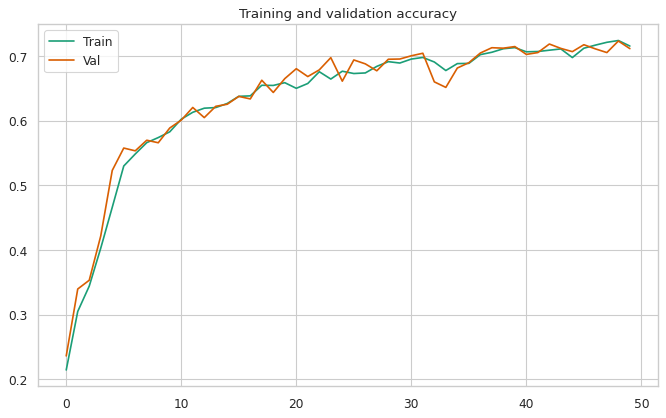

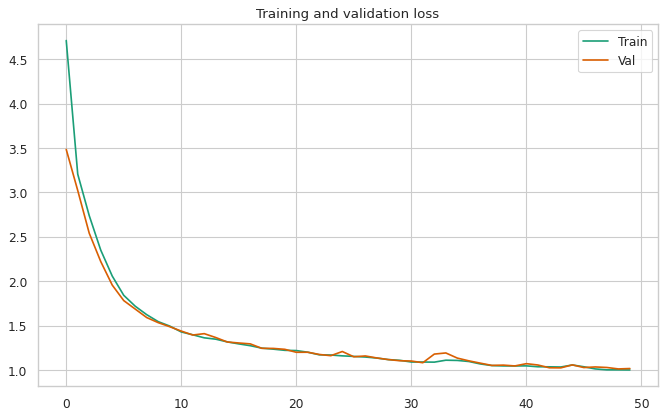

In [ ]:
#Plot loss and accuracy plots
acc1 = hist_1.history['accuracy']
val_acc1 = hist_1.history['val_accuracy']
loss1 = hist_1.history['loss']
val_loss1 = hist_1.history['val_loss']

epochs = range(len(acc1))

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, acc1, label='Training accuracy')
plt.plot(epochs, val_acc1, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, loss1, label='Training Loss')
plt.plot(epochs, val_loss1, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Train", "Val"]);

##Classification Report and Confusion Matrix

              precision    recall  f1-score   support

   Buildings       0.76      0.51      0.61       438
      Forest       0.91      0.91      0.91       454
     Glacier       0.58      0.88      0.70       480
    Mountain       0.71      0.60      0.65       502
         Sea       0.73      0.47      0.57       454
      Street       0.70      0.89      0.78       476

    accuracy                           0.71      2804
   macro avg       0.73      0.71      0.70      2804
weighted avg       0.73      0.71      0.70      2804



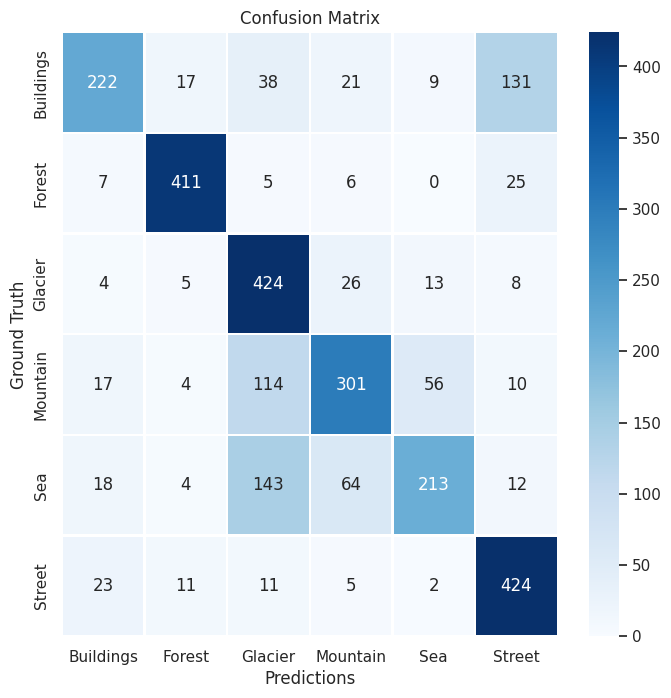

In [ ]:
conf_clf(y_test1, pred1)

#Weights Initialization

##Training

In [ ]:
#Create model with HeNormal initialization
model2 = MODEL(initializer = "HeNormal")

#Compile the model with optimizer and loss
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

epochs=50

#Model training
hist_2 = model2.fit(train_im,
                    validation_data=val_im,
                    epochs=epochs,
                    batch_size=batches,
                    verbose=2)

#Model Predictions
pred2 = np.argmax(model2.predict(test_imgs1, verbose=0),axis=1)

Epoch 1/50
11/11 - 19s - loss: 10.1680 - accuracy: 0.1937 - val_loss: 5.5163 - val_accuracy: 0.3185 - 19s/epoch - 2s/step
Epoch 2/50
11/11 - 17s - loss: 5.3281 - accuracy: 0.2589 - val_loss: 5.1241 - val_accuracy: 0.2607 - 17s/epoch - 2s/step
Epoch 3/50
11/11 - 17s - loss: 4.8961 - accuracy: 0.2896 - val_loss: 4.7317 - val_accuracy: 0.2903 - 17s/epoch - 2s/step
Epoch 4/50
11/11 - 17s - loss: 4.4952 - accuracy: 0.3212 - val_loss: 4.3543 - val_accuracy: 0.3245 - 17s/epoch - 2s/step
Epoch 5/50
11/11 - 17s - loss: 4.1389 - accuracy: 0.3169 - val_loss: 4.0126 - val_accuracy: 0.3655 - 17s/epoch - 2s/step
Epoch 6/50
11/11 - 17s - loss: 3.8320 - accuracy: 0.3952 - val_loss: 3.6961 - val_accuracy: 0.4932 - 17s/epoch - 2s/step
Epoch 7/50
11/11 - 17s - loss: 3.5520 - accuracy: 0.4638 - val_loss: 3.4774 - val_accuracy: 0.5235 - 17s/epoch - 2s/step
Epoch 8/50
11/11 - 17s - loss: 3.3515 - accuracy: 0.4957 - val_loss: 3.3077 - val_accuracy: 0.5439 - 17s/epoch - 2s/step
Epoch 9/50
11/11 - 17s - loss: 

##Loss and Accuracy Plot

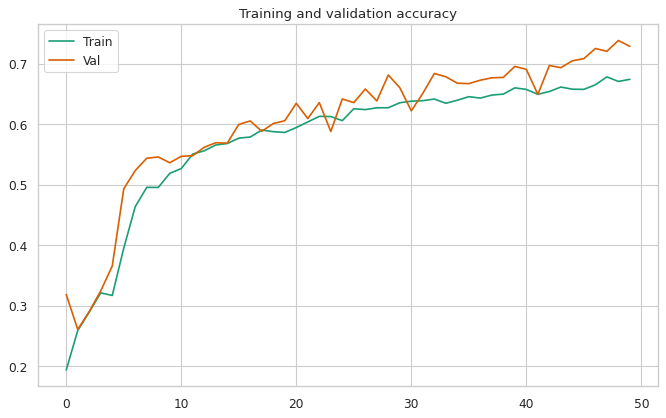

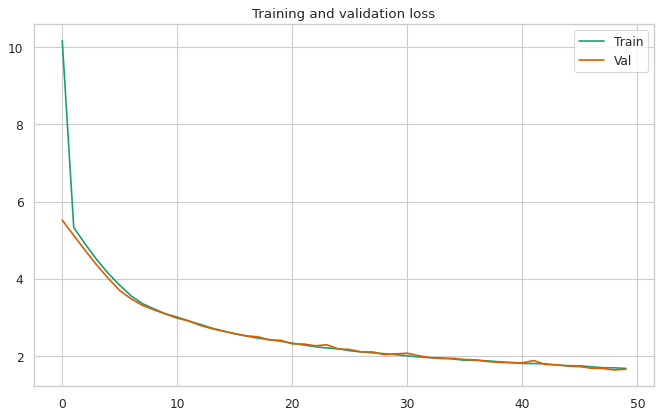

In [ ]:
acc2 = hist_2.history['accuracy']
val_acc2 = hist_2.history['val_accuracy']
loss2 = hist_2.history['loss']
val_loss2 = hist_2.history['val_loss']

epochs = range(len(acc2))

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, acc2, label='Training accuracy')
plt.plot(epochs, val_acc2, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, loss2, label='Training Loss')
plt.plot(epochs, val_loss2, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Train", "Val"]);

##Classification report and Confusion matrix

              precision    recall  f1-score   support

   Buildings       0.76      0.61      0.67       438
      Forest       0.89      0.92      0.90       454
     Glacier       0.66      0.79      0.72       480
    Mountain       0.68      0.63      0.65       502
         Sea       0.65      0.61      0.63       454
      Street       0.74      0.81      0.78       476

    accuracy                           0.73      2804
   macro avg       0.73      0.73      0.73      2804
weighted avg       0.73      0.73      0.73      2804



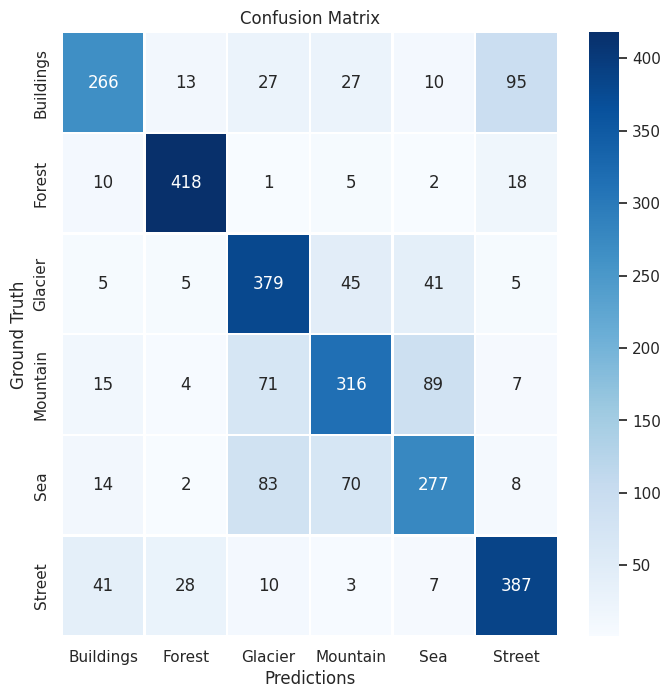

In [ ]:
conf_clf(y_test1, pred2)

#Learning Rate Decay

##Training

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

#Create model
model3 = MODEL(initializer = "GlorotUniform")

#Compile the model
model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 50
initial_learning_rate = 0.01

#ratio to decay the weight
decay = initial_learning_rate / epochs

#Function for the callback
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay * epoch)

#Declare callbacks
callbacks_list = [LearningRateScheduler(lr_time_based_decay, verbose=1)]


#Model training
hist_3 = model3.fit(train_im,
                    validation_data=val_im,
                    epochs=epochs,
                    batch_size=batches,
                    callbacks=callbacks_list,
                    verbose=2)

#Model Predictions
pred3 = np.argmax(model3.predict(test_imgs1, verbose=0),axis=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
11/11 - 21s - loss: 4.7033 - accuracy: 0.1858 - val_loss: 3.2470 - val_accuracy: 0.1740 - lr: 0.0010 - 21s/epoch - 2s/step

Epoch 2: LearningRateScheduler setting learning rate to 0.0009998000874799553.
Epoch 2/50
11/11 - 17s - loss: 3.0301 - accuracy: 0.2487 - val_loss: 2.8099 - val_accuracy: 0.3951 - lr: 9.9980e-04 - 17s/epoch - 2s/step

Epoch 3: LearningRateScheduler setting learning rate to 0.0009994002858602087.
Epoch 3/50
11/11 - 17s - loss: 2.5441 - accuracy: 0.4111 - val_loss: 2.3551 - val_accuracy: 0.5203 - lr: 9.9940e-04 - 17s/epoch - 2s/step

Epoch 4: LearningRateScheduler setting learning rate to 0.0009988009951623015.
Epoch 4/50
11/11 - 17s - loss: 2.1905 - accuracy: 0.4938 - val_loss: 2.0617 - val_accuracy: 0.5264 - lr: 9.9880e-04 - 17s/epoch - 2s/step

Epoch 5: LearningRateScheduler setting learning rate to 0.0009980025676285312.
Epoch 5/50
11/11 - 18s - loss: 1.9264 - accuracy: 0.

##Loss and Accuracy Plot

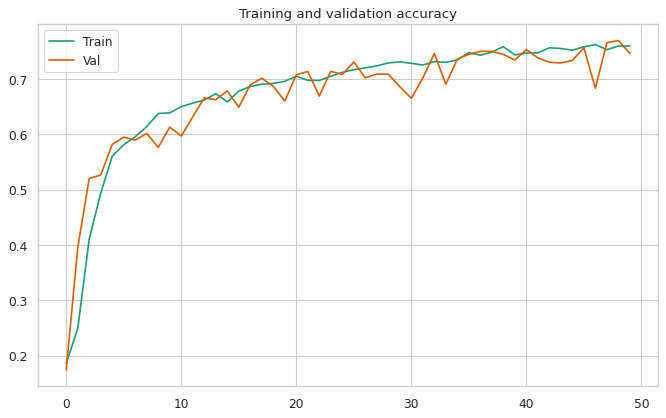

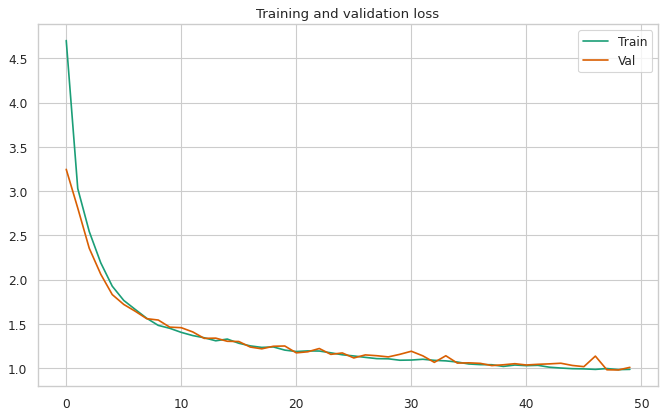

In [ ]:
acc3 = hist_3.history['accuracy']
val_acc3 = hist_3.history['val_accuracy']
loss3 = hist_3.history['loss']
val_loss3 = hist_3.history['val_loss']

epochs = range(len(acc3))

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, acc3, label='Training accuracy')
plt.plot(epochs, val_acc3, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, loss3, label='Training Loss')
plt.plot(epochs, val_loss3, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Train", "Val"]);

##Confusion matrix and Classification Report

              precision    recall  f1-score   support

   Buildings       0.86      0.58      0.69       438
      Forest       0.93      0.93      0.93       454
     Glacier       0.59      0.86      0.70       480
    Mountain       0.69      0.66      0.67       502
         Sea       0.74      0.60      0.66       454
      Street       0.79      0.85      0.82       476

    accuracy                           0.75      2804
   macro avg       0.77      0.75      0.75      2804
weighted avg       0.76      0.75      0.74      2804



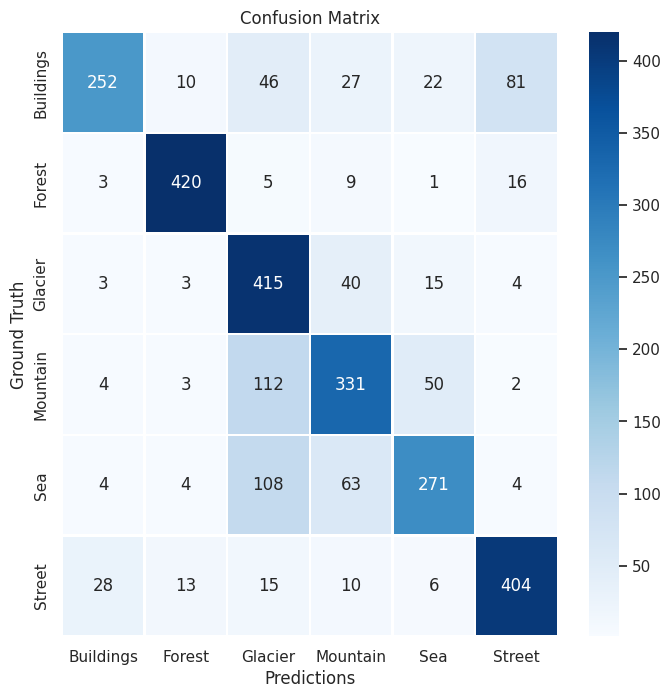

In [ ]:
conf_clf(y_test1, pred3)

#Batch Size

In [ ]:
#Data Generator
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

#Batch size
batches = 512

#Training generator
train_im = datagen.flow_from_directory(
    base_dir,
    batch_size=batches,
    target_size=(150,150),
    class_mode="categorical",
    subset="training"
)

#Validation generator
val_im = datagen.flow_from_directory(
    base_dir,
    batch_size=batches,
    target_size=(150,150),
    class_mode="categorical",
    subset="validation",
)


#Test images in numpy array
test_img_path = val_im.filepaths
test_imgs2 = []
for img in test_img_path:
  img_array = imread(img)
  img_resize = resize(img_array, (150,150,3))
  test_imgs2.append(img_resize)
test_imgs2=np.array(test_imgs2)

#True test labels
ytest2 = val_im.classes

#Create model
model4 = MODEL(initializer = "GlorotUniform")

#Compile model
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 50

#Train the model
hist_4 = model4.fit(train_im,
                    validation_data=val_im,
                    epochs=epochs,
                    batch_size=batches,
                    verbose=2)

#Model Predictions
pred4 = np.argmax(model4.predict(test_imgs2, verbose=0),axis=1)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/50
22/22 - 21s - loss: 3.5737 - accuracy: 0.3125 - val_loss: 2.6354 - val_accuracy: 0.3623 - 21s/epoch - 946ms/step
Epoch 2/50
22/22 - 18s - loss: 2.2012 - accuracy: 0.5015 - val_loss: 1.9543 - val_accuracy: 0.5453 - 18s/epoch - 803ms/step
Epoch 3/50
22/22 - 16s - loss: 1.7712 - accuracy: 0.5685 - val_loss: 1.6786 - val_accuracy: 0.5592 - 16s/epoch - 743ms/step
Epoch 4/50
22/22 - 16s - loss: 1.5842 - accuracy: 0.5869 - val_loss: 1.5205 - val_accuracy: 0.6063 - 16s/epoch - 743ms/step
Epoch 5/50
22/22 - 16s - loss: 1.4808 - accuracy: 0.6085 - val_loss: 1.4551 - val_accuracy: 0.6152 - 16s/epoch - 743ms/step
Epoch 6/50
22/22 - 16s - loss: 1.4049 - accuracy: 0.6199 - val_loss: 1.3847 - val_accuracy: 0.6255 - 16s/epoch - 744ms/step
Epoch 7/50
22/22 - 16s - loss: 1.3631 - accuracy: 0.6248 - val_loss: 1.3436 - val_accuracy: 0.6320 - 16s/epoch - 741ms/step
Epoch 8/50
22/22 - 16s - loss: 1.3162 - accurac

##Loss and Accuracy Plot

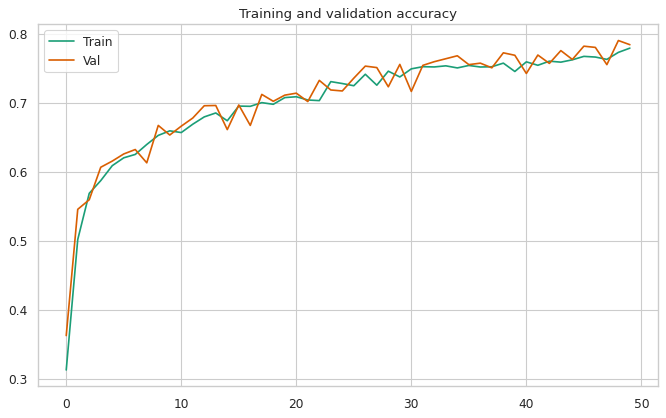

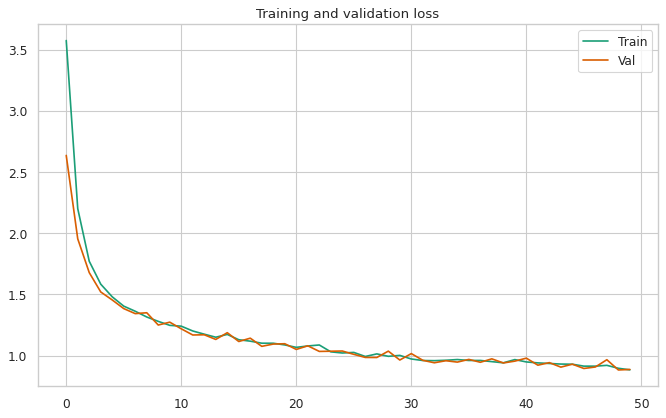

In [ ]:
acc4 = hist_4.history['accuracy']
val_acc4 = hist_4.history['val_accuracy']
loss4 = hist_4.history['loss']
val_loss4 = hist_4.history['val_loss']

epochs = range(len(acc4))

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, acc4, label='Training accuracy')
plt.plot(epochs, val_acc4, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(["Train", "Val"])

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, loss4, label='Training Loss')
plt.plot(epochs, val_loss4, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(["Train", "Val"]);

##Confusion matrix and classification report

              precision    recall  f1-score   support

   Buildings       0.78      0.75      0.76       438
      Forest       0.92      0.94      0.93       454
     Glacier       0.74      0.77      0.76       480
    Mountain       0.76      0.64      0.70       502
         Sea       0.68      0.82      0.75       454
      Street       0.83      0.79      0.81       476

    accuracy                           0.78      2804
   macro avg       0.79      0.79      0.78      2804
weighted avg       0.79      0.78      0.78      2804



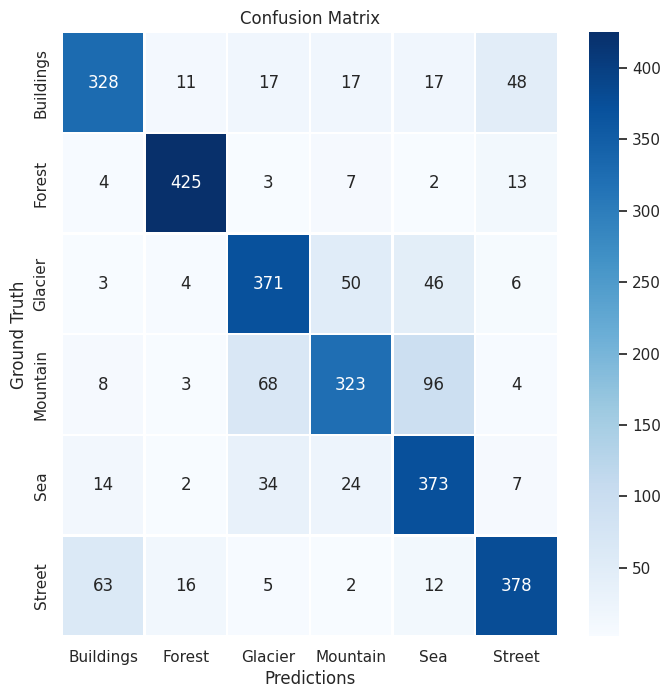

In [ ]:
conf_clf(ytest2, pred4)

#Comparison

##Learning curves

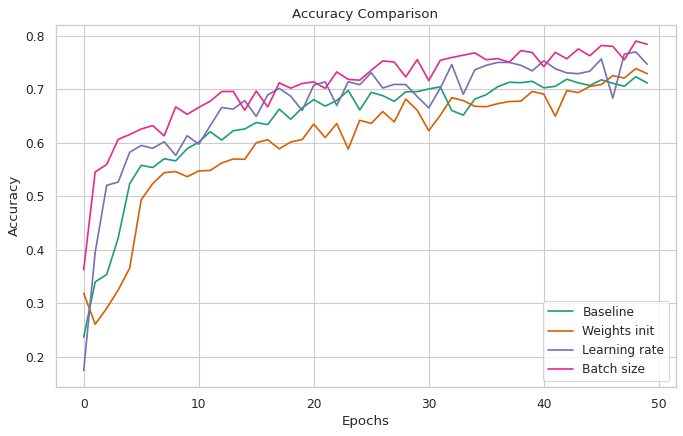

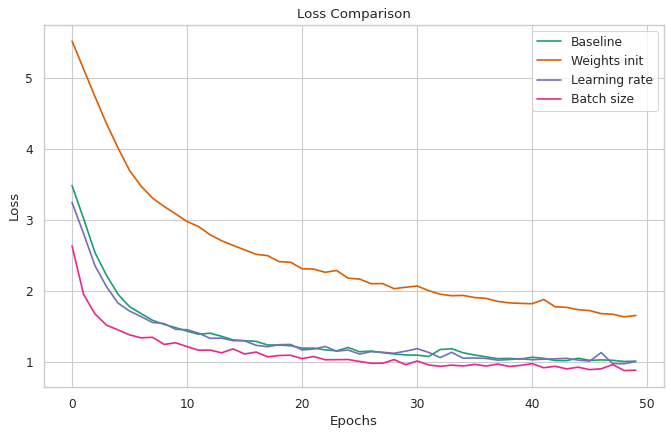

In [ ]:
plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, val_acc1, label='Baseline')
plt.plot(epochs, val_acc2, label='Weights init')
plt.plot(epochs, val_acc3, label='Learning rate')
plt.plot(epochs, val_acc4, label='Batch size')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend();

plt.figure(figsize=(10,6), dpi=80)
plt.plot(epochs, val_loss1, label='Baseline')
plt.plot(epochs, val_loss2, label='Weights init')
plt.plot(epochs, val_loss3, label='Learning rate')
plt.plot(epochs, val_loss4, label='Batch size')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend();

##Each Trick Accuracy

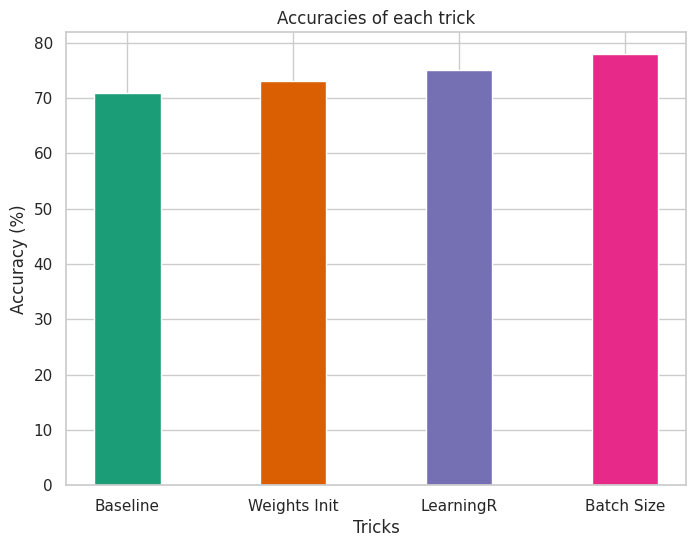

In [ ]:
baseline = 71
weightI = 73
learR = 75
batchS = 78

x = np.arange(4)
y1 = [baseline, weightI, learR, batchS]

width = 0.4

sns.set_theme(style='whitegrid', palette='Dark2')
plt.figure(figsize=(8,6), dpi=100)
plt.bar(x, y1, width, color=['C0','C1','C2','C3'])
plt.xlabel("Tricks")
plt.ylabel("Accuracy (%)")
plt.title('Accuracies of each trick')
plt.xticks(x, ['Baseline', 'Weights Init', 'LearningR', 'Batch Size']);